In [1]:
#Below are quick pieces of code I wrote to make submission into Kaggle DSTL competition. Thanks to Kaggle community
# discussions and code snippets which I have used below

#Import Libraries and configure parameters
import os
import cv2
import pandas as pd
import numpy as np
import json
from shapely.wkt import loads
import matplotlib
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import tifffile as tiff
from pprint import pprint
from matplotlib.collections import PatchCollection
from matplotlib import path
import shapely.geometry
from shapely.geometry import MultiPolygon
import theano
import theano.tensor as T
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d
from PIL import Image
from math import *
import shapely
import descartes
from descartes import PolygonPatch
import random

theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'
theano.config.compute_test_value = 'warn'
%matplotlib inline

data_dir = '../data/'
images_dir = '../data/three_band/'
geo_dir = '../data/train_geojson_v3/'
wkt_dir = '../data/'
image_arr_dir = '../outputClassArrays/'
STANDING_WATER_train_polygon = '../data/train_polygon/STANDING_WATER/'
train_polygon = '../data/train_polygon/'
train_images = '../data/train_images_v1/'
full_train_images = '../data/train_images_v2/'
full_test_images = '../data/test_images/'
list_of_train_images = ['6010_1_2','6010_4_4','6040_1_3','6040_4_4','6070_2_3','6100_1_3','6100_2_3','6110_3_1' 
                        ,'6120_2_0','6140_1_2','6150_2_3','6170_0_4','6170_4_1',
'6010_4_2','6040_1_0','6040_2_2','6060_2_3','6090_2_0','6100_2_2','6110_1_2','6110_4_0','6120_2_2','6140_3_1','6160_2_1','6170_2_4']

tcnames = {}
filename_to_classType = {
'001_MM_L2_LARGE_BUILDING':1,
'001_MM_L3_RESIDENTIAL_BUILDING':1,
'001_MM_L3_NON_RESIDENTIAL_BUILDING':1,
'001_MM_L5_MISC_SMALL_STRUCTURE':2,
'002_TR_L3_GOOD_ROADS':3,
'002_TR_L4_POOR_DIRT_CART_TRACK':4,
'002_TR_L6_FOOTPATH_TRAIL':4,
'006_VEG_L2_WOODLAND':5,
'006_VEG_L3_HEDGEROWS':5,
'006_VEG_L5_GROUP_TREES':5,
'006_VEG_L5_STANDALONE_TREES':5,
'007_AGR_L2_CONTOUR_PLOUGHING_CROPLAND':6,
'007_AGR_L6_ROW_CROP':6, 
'008_WTR_L3_WATERWAY':7,
'008_WTR_L2_STANDING_WATER':8,
'003_VH_L4_LARGE_VEHICLE':9,
'003_VH_L5_SMALL_VEHICLE':10,
'003_VH_L6_MOTORBIKE':10}


Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
#For better visualization of input images
def scale_percentile(matrix):
    """Fixes the pixel value range to 2%-98% original distribution of values"""
    orig_shape = matrix.shape
    matrix = np.reshape(matrix, [matrix.shape[0]*matrix.shape[1], 3]).astype(float)
    
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    
    matrix = (matrix - mins[None,:])/maxs[None,:]
    matrix = np.reshape(matrix, orig_shape)
    matrix = matrix.clip(0,1)
    return matrix

In [3]:
def scale_coords(w,h,c,grid_name, point):
    """Scale the coordinates of a polygon into the image coordinates for a grid cell"""
    Xmax, Ymin = grid_sizes.ix[grid_name][['Xmax', 'Ymin']]

    x,y = point[:,0], point[:,1]

    wp = float(w**2)/(w+1)
    xp = x/Xmax*wp

    hp = float(h**2)/(h+1)
    yp = y/Ymin*hp

    return np.concatenate([xp[:,None],yp[:,None]], axis=1)

In [4]:
# Load JSON of image overlays, and convert it into image coordinates
def load_overlays(tif_data, tile_name):
    """Get all of the polygon overlays for a tile.
    Returns a dict: {LABEL: POLYGON}"""
    dirname = os.path.join(geo_dir, '%s/'%tile_name)
    fnames = [os.path.join(dirname, fname) for fname in 
              os.listdir(dirname) 
              if fname.endswith('.geojson') and not fname.startswith('Grid')]
    
    overlays = dict()
    for fname in fnames:
        with open(fname, 'r') as f:
            sh_json = json.load(f)
        label = sh_json['features'][0]['properties']['LABEL']
        
        polygons = []
        for sh in sh_json['features']:
            pts = scale_coords(tif_data, grid_name, np.array(sh['geometry']['coordinates'][0])).squeeze()

            # Remove badly formatted polygons
            if not ((len(pts.shape)==2) and (pts.shape[1]==2) and (pts.shape[0] > 2)):
                continue
            polygons.append(pts)
            
        overlays[label] = polygons

    return overlays
    


In [6]:
def polygon_to_masks(tile_name,c_name):
    """Get all of the polygon overlays for a tile.
    Returns a dict: {LABEL: POLYGON}"""
    tif_data = tiff.imread(images_dir + tile_name + '.tif').transpose([1,2,0])
    #print tif_data.shape
    w,h,c = (min(tif_data.shape[1],3400),min(tif_data.shape[0],3400),3)
    #w,h,c = tif_data.shape
    dirname = os.path.join(geo_dir, '%s/'%tile_name)
    fnames = [os.path.join(dirname, fname) for fname in 
              os.listdir(dirname) 
              if fname.endswith('.geojson') and not fname.startswith('Grid')]

    sh_json = {'features':''}
    overlays = dict()
    for fname in fnames:
        if c_name in fname:
            with open(fname, 'r') as f:
                sh_json = json.load(f)
        
    # Scale the polygon coordinates to match the pixels
    polys = []
    for sh in sh_json['features']:
        geom = np.array(sh['geometry']['coordinates'][0])
        if geom.ndim == 2:
            geom_fixed = scale_coords(w,h,c,tile_name, geom)

            pts = geom_fixed.astype(int)
            polys.append(pts)
    
    # Create an empty mask and then fill in the polygons
    mask = np.zeros((w,h))
    #print polys
    cv2.fillPoly(mask, polys, 1)
    mask = mask.astype(bool)
    #plt.imshow(mask)
    return mask
    #print(mask)

In [7]:
#Converting input polygons to readable inputs
def write_all_polygons():
    for dname in os.listdir(geo_dir):
        if dname.startswith('6') and dname in pn:
                full_mask = np.full((3400, 3400), False)
                for fname in os.listdir(geo_dir + dname):
                    temp = fname.split('.')[0]
                    if temp in filename_to_classType:
                        mask = polygon_to_masks(dname, fname) 
                        i = 0
                        cindex = filename_to_classType[temp]
                        for (x_index, y) in np.ndenumerate(mask):
                            if x_index[0] < 3400 and x_index[1] < 3400:
                                if y != 0:
                                    full_mask[x_index] = y*cindex
                                    
                np.save(train_polygon + dname + 'poly', full_mask) 
    

In [8]:
#Converting input images to readable inputs
def write_all_images():
    for fname in os.listdir(images_dir):
        if fname in list_of_train_images:
            print fname
            tif_data = tiff.imread(images_dir + fname).transpose([1,2,0])
            fixed_im = scale_percentile(tif_data)
            full_mask = np.full((3400, 3400,3), 0)
            
            for (x_index,y) in np.ndenumerate(fixed_im):
                if x_index[0] < 3400 and x_index[1] < 3400:
                    full_mask[x_index] = y
            
            np.save(full_train_images + fname , full_mask) 
            

In [9]:
def load_image_files():
    for fname in os.listdir(STANDING_WATER_train_polygon):
        mask = np.load(STANDING_WATER_train_polygon+fname)
        if True in mask[:, :]:
            #An example image below
            if fname == '6140_3_1_168.npy':
                plt.imshow(mask)
            print fname

In [10]:
#Testing image sizes
def list_all_image_sizes():
    for fname in os.listdir(images_dir):
        if fname.startswith('6'):
            print fname
            tif_data = tiff.imread(images_dir + fname).transpose([1,2,0])
            print tif_data.shape

In [12]:
#Read Grid sizes of each CSV
#Load files box
wkt = pd.read_csv(wkt_dir + 'train_wkt_v4.csv')

# Load grid CSV
grid_sizes = pd.read_csv(os.path.join(data_dir, 'grid_sizes.csv'), index_col=0)


../ImagesDSTL/../Files/train_geojson_v3/6100_1_3/008_WTR_L2_STANDING_WATER.geojson


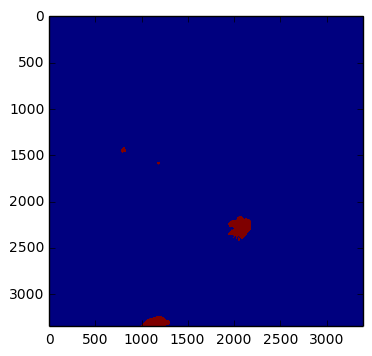

In [45]:
mask = polygon_to_masks(grid_name,'STANDING_WATER')

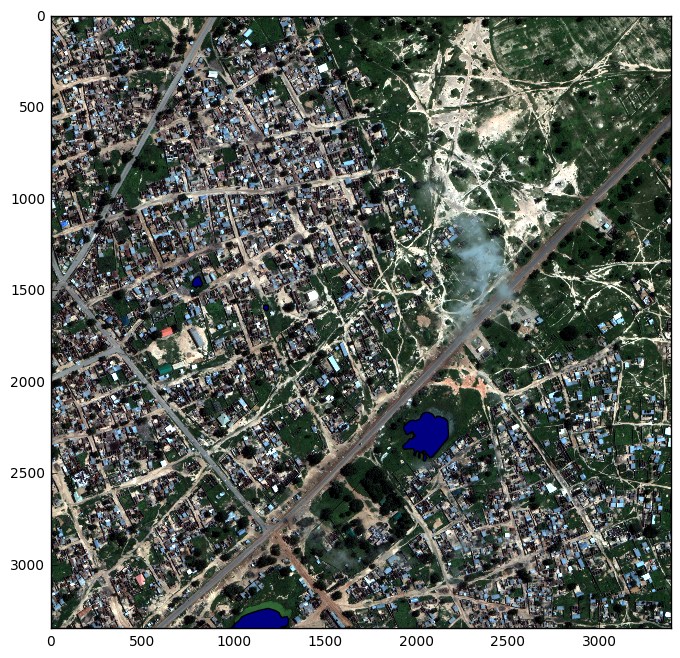

In [38]:
#Sample code to plot polygon on top of live image.
tif_data = tiff.imread(images_dir + grid_name + '.tif').transpose([1,2,0])
fixed_im = scale_percentile(tif_data)

overlays_poly = load_overlays(tif_data, grid_name)

fig, ax = plt.subplots(figsize=(8,8))
patches = []
for pts in overlays_poly['STANDING_WATER']:
    poly = Polygon(pts)
    patches.append(poly)

p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=1.0)

#colors = 100*np.random.rand(len(patches))
colors = []
for pa in patches:
    colors.append(0)
p.set_array(np.array(colors))

ax.imshow(fixed_im)
ax.add_collection(p)
plt.show()

In [13]:
#Truncate input test images
def write_all_test_images():
    for fname in os.listdir(images_dir)[100:]:
        if fname not in list_of_train_images:
            print fname
            tif_data = tiff.imread(images_dir + fname).transpose([1,2,0])
            fixed_im = scale_percentile(tif_data)

            full_mask = np.full((3400, 3400,3), 0)
            
            for (x_index,y) in np.ndenumerate(fixed_im):
                if x_index[0] < 3400 and x_index[1] < 3400:
                    full_mask[x_index] = y
            print full_test_images + fname
            np.save(full_test_images + fname , full_mask) 
            

In [15]:
#Reading Image class from sample excel file given as part of competition.
def get_image_class(wkt, iname,cl):
    
    i = 0
    demp = ''
    for row in wkt['ImageId']:
        if row == iname:
            break
        i += 1
    
    j = 0
    for row in wkt['ClassType'][i:]:
        if row == cl:
            break
        j += 1
    
    for row in wkt['MultipolygonWKT'][i+j:i+j+1]:
        demp = row
    
    return demp


In [16]:
#Function to plot polygons on a canvas
def plot_bad_poly(badPolys):
    fig, ax = plt.subplots(figsize=(8,8))
    for badPoly in badPolys:

        ax.set_xlim([0, 0.009188])
        ax.set_ylim([-0.0090400000000000012, 0])
        pp = PolygonPatch(badPoly, facecolor=(0,1,0), edgecolor=(1,0,0), alpha=1)
        ax.add_patch(pp)
    return ax

#ax = plot_bad_poly(shapely.wkt.loads(get_image_class(pd.read_csv(wkt_dir + 'train_wkt_v4.csv'),'6140_1_2',6)))

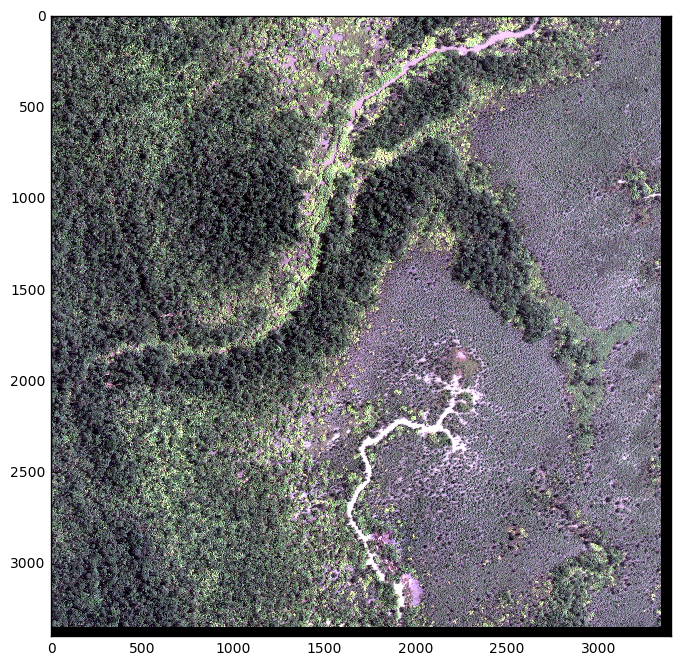

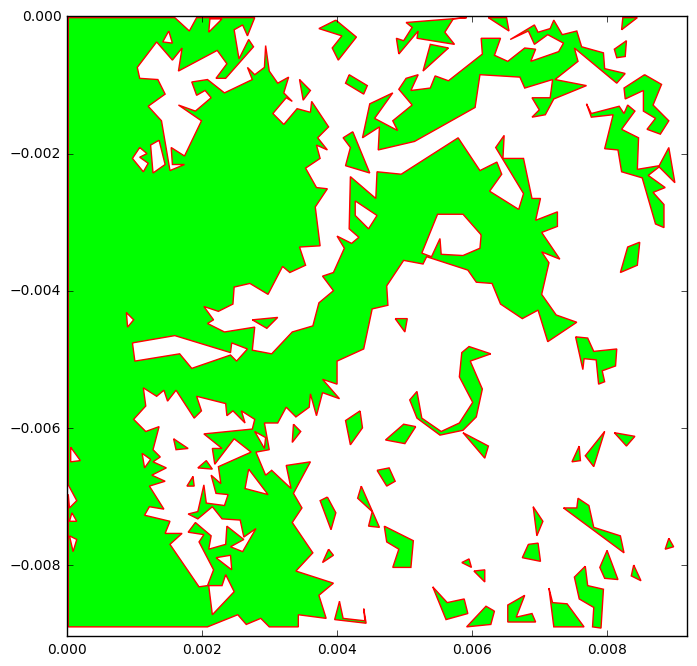

In [22]:
#Plotting sample images
#Below example shows the trained output where the modified Unet detected particular class in test image.
def plot_test(iname,cl):
    test_x = np.load('../data/test_images/'+iname+'.tif.npy')

    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(test_x)

    wkt = pd.read_csv('../data/submission/' + '1.csv')
    #print(wkt)
    #wkt = 'MULTIPOLYGON (((0.0048626018028259 -0.0077761738586426, 0.0048626018028259 -0.0079705782051086, 0.0050061472434998 -0.0079529050827026, 0.0049702608833313 -0.0078468663482666, 0.0048984881629944 -0.0078291932258606, 0.0048984881629944 -0.0077761738586426, 0.0048626018028259 -0.0077761738586426)), ((0.0020993520698547 -0.0055847066802979, 0.0020993520698547 -0.0056377260475159, 0.0022249543304443 -0.0056200529251099, 0.0022249543304443 -0.0055847066802979, 0.0020993520698547 -0.0055847066802979)), ((0.0047011131820679 -0.0044536268463135, 0.0046472836418152 -0.0044536268463135, 0.0045396245613098 -0.0045243193359375, 0.0047011131820679 -0.0044536268463135)))'
    
    plot_bad_poly(shapely.wkt.loads(get_image_class(wkt, iname,cl)))
    #plot_bad_poly(shapely.wkt.loads(wkt))
    
plot_test('6070_1_2',6)